In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exports.e_12_GeneralReLU import *

# Batch Normalization

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, n_inp, mntm=0.1, eps=1e-5):
        super().__init__()
        self.mntm, self.eps = mntm, eps
        
        self.gamma = nn.Parameter(torch.ones (n_inp, 1, 1))
        self.beta  = nn.Parameter(torch.zeros(n_inp, 1, 1))

        self.register_buffer('means', torch.zeros(1, n_inp, 1, 1))
        self.register_buffer('vars',  torch.ones (1, n_inp, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var ((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mntm)
        self.vars .lerp_(v, self.mntm)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x*self.gamma + self.beta

In [4]:
#--export--#
def conv_GReLU(n_inp, n_out, kernel_size=3, stride=2, btch_norm=True, **kwargs):
    layers = [nn.Conv2d(n_inp, n_out,
                       kernel_size,
                       padding=kernel_size//2,
                       stride=stride,
                       bias = not btch_norm),
              GReLU(**kwargs)]
    if btch_norm: layers.append(BatchNorm(n_out))
    
    return nn.Sequential(*layers)

def cnn_layers_GReLU(data_w, n_kernels, **kwargs):
    n_kernels = [1] + n_kernels
    
    return [
        conv_GReLU(n_kernels[i], n_kernels[i+1], 5 if i==0 else 3, **kwargs)
        for i in range(len(n_kernels)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(n_kernels[-1], data_w.n_out)]

In [11]:
GReLU_params = {'leak': 0.1, 'sub': 0.4, 'maxv': 7.}

kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = nn.Sequential(*cnn_layers_GReLU(data_w, kernel_ns, **GReLU_params))
model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.7),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])

for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        if getattr(l[0], 'bias', None) is not None: l[0].bias.data.zero_()

In [6]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(3, model_w)

train: [0.4992571875]
valid: [0.2605493408203125]
train: [0.167412265625]
valid: [0.13568192138671875]
train: [0.11703796875]
valid: [0.117383447265625]


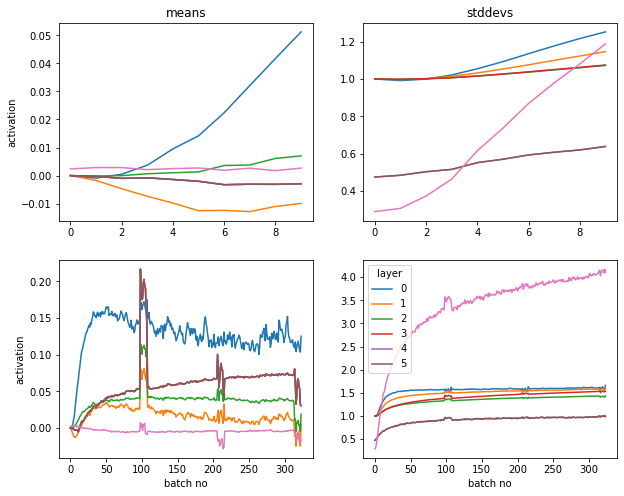

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for h in hooks:
    means, stds, _ = h.stats
    ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
    ax[1,0].plot(means); ax[1,1].plot(stds)
    ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
    for a in ax[1]: a.set_xlabel('batch no')
    for a in ax[:, 0]: a.set_ylabel('activation')
    plt.legend(range(6), title='layer')

In [12]:
sched = combine_schedules([0.5, 0.5],
                          [sched_cosine(0.1, 1.2),
                           sched_cosine(1.2, 0.2)]) 

# add annealing callbacks
cbs = [BatchTransformCB(mnist_view),
       Recorder(),
       AvgStatsCB([acc_f]),
       ParamScheduler('lr', sched)]

job = DLJob(cbs)

In [13]:
with Hooks(model, append_stats_hist_GReLU) as hooks: job.fit(3, model_w)

train: [0.964600546875, tensor(0.7300)]
valid: [0.260396826171875, tensor(0.9193)]
train: [0.17809373046875, tensor(0.9462)]
valid: [0.1294649658203125, tensor(0.9625)]
train: [0.1079597265625, tensor(0.9678)]
valid: [0.100742041015625, tensor(0.9706)]


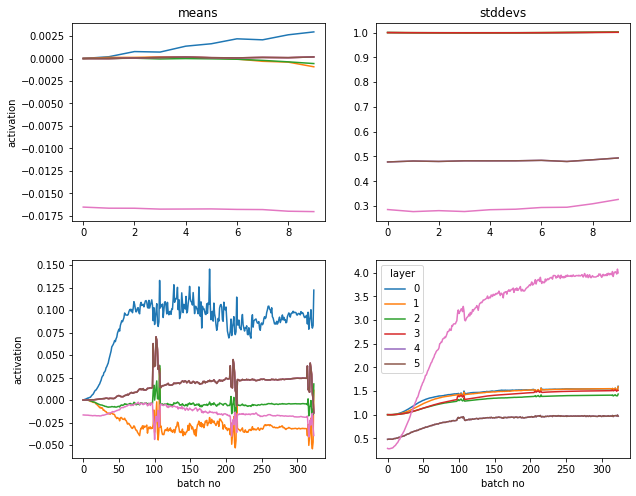

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for h in hooks:
    means, stds, _ = h.stats
    ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
    ax[1,0].plot(means); ax[1,1].plot(stds)
    ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
    for a in ax[1]: a.set_xlabel('batch no')
    for a in ax[:, 0]: a.set_ylabel('activation')
    plt.legend(range(6), title='layer')

### Something weird happens at the end of each epoch...